# 4. Training a Machine Learning Classifier for HP-PPI Prediction Task

Classifier: Logistic Regression

In [1]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from skopt import BayesSearchCV

from IPython.display import display, Markdown

# Suppress warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning, ChangedBehaviorWarning

warnings.simplefilter('ignore', category=(UndefinedMetricWarning,
                                          ChangedBehaviorWarning,
                                          UserWarning,
                                          DeprecationWarning,
                                          RuntimeWarning))

/home/rei/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Set up directories
SEED = 149028763
parent_dir = os.path.dirname(os.getcwd())

dir_in = os.path.join(parent_dir, 'processed_data', 'features')
dir_out = os.path.join(parent_dir, 'analyses')

In [3]:
# Function for combining datasets
def get_dataset(pathogens):
    '''Combine features and labels of different pathogen datasets'''
    
    X = []
    y = []
    
    # Iterate through datasets
    for pathogen in pathogens:
        f_in = os.path.join(dir_in, '%s_features.pkl' % pathogen)
        X_, y_ = joblib.load(f_in)
        X.append(X_)
        y.append(y_)
    
    # Combine features (X) and labels (y)
    X = sparse.vstack(X)
    y = np.concatenate(y)
    
    return X, y

In [4]:
# Load all datasets
pathogens = ['Bacan', 'Yerpe', 'Fratu']
X, y = get_dataset(pathogens)
print('Loaded %i samples with %i features' % X.shape)

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y,
                                                    random_state=SEED)

Loaded 105822 samples with 4456 features


## Hyperparameter Tuning

Bayesian search on `LogisticRegression` with `BayesSearchCV`

In [5]:
# Set up classifier pipeline
estimator = LogisticRegression(solver='liblinear', penalty='l1',
                               max_iter=2000, random_state=SEED)

pipe = Pipeline([('scaler', MaxAbsScaler()), ('clf', estimator)])

In [6]:
# Callback function
def status_print(optim_result):
    """Status callback durring Bayesian hyperparameter search"""
    
    # Get current parameters and the best parameters 
    n = len(pd.DataFrame(opt.cv_results_))
    print('Iteration %i, best %s score: %.6f'\
          % (n, scoring, opt.best_score_))

In [7]:
# Perform hyperparameter optimization
param_space = {'clf__C': (1, 5, 'uniform')}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scoring = 'neg_log_loss'

opt = BayesSearchCV(pipe, param_space,cv=cv, scoring=scoring, n_iter=20,
                    n_jobs=5, verbose=0, random_state=SEED)

cv_results = opt.fit(X_train, y_train, callback=status_print)

Iteration 1, best neg_log_loss score: -0.112972
Iteration 2, best neg_log_loss score: -0.109703
Iteration 3, best neg_log_loss score: -0.109701
Iteration 4, best neg_log_loss score: -0.109701
Iteration 5, best neg_log_loss score: -0.109701
Iteration 6, best neg_log_loss score: -0.109701
Iteration 7, best neg_log_loss score: -0.109701
Iteration 8, best neg_log_loss score: -0.109701
Iteration 9, best neg_log_loss score: -0.109701
Iteration 10, best neg_log_loss score: -0.109701
Iteration 11, best neg_log_loss score: -0.109701
Iteration 12, best neg_log_loss score: -0.109701
Iteration 13, best neg_log_loss score: -0.109701
Iteration 14, best neg_log_loss score: -0.109701
Iteration 15, best neg_log_loss score: -0.109701
Iteration 16, best neg_log_loss score: -0.109701
Iteration 17, best neg_log_loss score: -0.109701
Iteration 18, best neg_log_loss score: -0.109701
Iteration 19, best neg_log_loss score: -0.109701
Iteration 20, best neg_log_loss score: -0.109701


In [8]:
# Set best estimator as classifier
opt.best_params_

print('Test %s score: %.4f' % (scoring, opt.score(X_test, y_test)))
pipe = opt.best_estimator_

{'clf__C': 2.6374624571220413}

Test neg_log_loss score: -0.0988


In [9]:
# Define custom function for generating confusion matrices
def plot_confusion_matrix(y_true, y_pred, labels, cmap=plt.cm.Blues):
    '''
    Generate a confusion matrix from true and predicted labels.
    '''
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Normalize confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm, interpolation='nearest', cmap=cmap)
    plt.colorbar(mappable=im)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels,
           yticklabels=labels,
           title='Confusion Matrix\n',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = cm_norm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, '{:.2f}%\n({})'.format(cm_norm[i, j]*100, cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm_norm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

              precision    recall  f1-score   support

           0     0.9783    0.9981    0.9881     19657
           1     0.9666    0.7109    0.8193      1508

    accuracy                         0.9777     21165
   macro avg     0.9724    0.8545    0.9037     21165
weighted avg     0.9774    0.9777    0.9761     21165



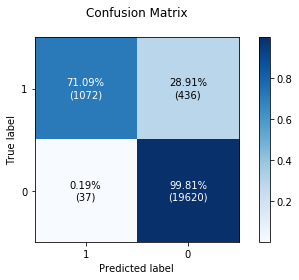

In [10]:
# Evaluate model

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)

print(classification_report(y_test, y_pred, digits=4))

# Plot metrics
_ = plot_confusion_matrix(y_test, y_pred, labels=[1,0])
_ = plt.show()

## Evaluate model on partitioned datasets

                               Test 1                                
                          Test Pathogen: Bacan
                          
              precision    recall  f1-score   support

           0     0.9746    0.9620    0.9683     36476
           1     0.5716    0.6686    0.6163      2764

    accuracy                         0.9414     39240
   macro avg     0.7731    0.8153    0.7923     39240
weighted avg     0.9462    0.9414    0.9435     39240



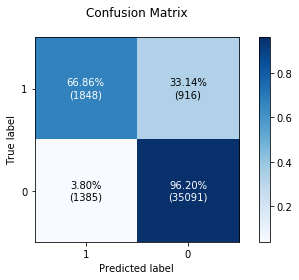

<hr></hr>

                               Test 2                                
                          Test Pathogen: Yerpe
                          
              precision    recall  f1-score   support

           0     0.9738    0.9747    0.9742     49151
           1     0.6491    0.6409    0.6450      3590

    accuracy                         0.9520     52741
   macro avg     0.8114    0.8078    0.8096     52741
weighted avg     0.9517    0.9520    0.9518     52741



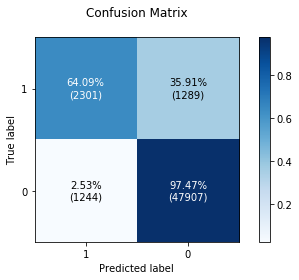

<hr></hr>

                               Test 3                                
                          Test Pathogen: Fratu
                          
              precision    recall  f1-score   support

           0     0.9762    0.9783    0.9773     12654
           1     0.7636    0.7456    0.7545      1187

    accuracy                         0.9584     13841
   macro avg     0.8699    0.8620    0.8659     13841
weighted avg     0.9580    0.9584    0.9582     13841



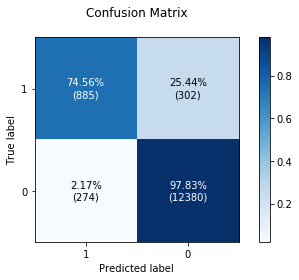

<hr></hr>

In [11]:
# Train and test classifier on different datasets
## Partition datasets by pathogen species
%matplotlib inline
i = 0 # track number of tests

for p_test in pathogens:
    p_train = [p for p in pathogens if p != p_test]
    X_train, y_train = get_dataset(p_train)
    
    # Train pipeline
    _ = pipe.fit(X_train, y_train)
    
    # Evaluate performance on test set
    X_test, y_test = get_dataset([p_test])
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)
    
    i += 1
    
    print('Test %i'.center(70) % i)
    print('Test Pathogen: %s\n'.center(70) % p_test)
    print(classification_report(y_test, y_pred, digits=4))
    
    # Plot metrics
    _ = plot_confusion_matrix(y_test, y_pred, labels=[1,0])
    _ = plt.show()
    
    display(Markdown('<hr></hr>'))

In [12]:
# Refit model with the whole dataset
_ = pipe.fit(X, y)

# Dump model as pickle
_ = joblib.dump(pipe, 'best_model.pkl')

## Examine feature importances from coefficients

In [13]:
# Get Pfam domains as feature names
f_in = os.path.join(parent_dir, 'processed_data', 'pfam_domain_descriptions.tsv')
df_pfam = pd.read_csv(f_in, sep='\t', index_col='Pfam_ID')

df_pfam.shape
df_pfam.head()

(4456, 2)

,Description,Coefficient
Pfam_ID,,
PF00001,7 transmembrane receptor (rhodopsin family),-10.014368
PF00002,7 transmembrane receptor (Secretin family),2.333709
PF00004,ATPase family associated with various cellular...,0.510560
PF00005,ABC transporter,-0.207467
PF00006,"ATP synthase alpha/beta family, nucleotide-bin...",0.175299


In [14]:
# Get model coefficients
pipe = joblib.load('best_model.pkl')
coefs = pipe['clf'].coef_[0]

# Append coefficients to Pfam DataFrame
df_pfam['Coefficient'] = coefs

# Replace domain DataFrame file with the one appended with coefficients
df_pfam.to_csv(f_in, sep='\t')

In [15]:
# Obtain summary of feature relevance

# Function for viewing a slice of the domain lists
def print_domains(df_features):
    return 

pos_features = df_pfam[df_pfam.Coefficient > 0]
zero_features = df_pfam[df_pfam.Coefficient == 0]
neg_features = df_pfam[df_pfam.Coefficient < 0]

print('Domains that support interaction: %i' % len(pos_features))
pos_features.sort_values(by='Coefficient', ascending=False)[:10]

print('\nDomains irrelevant for interaction: %i' % len(zero_features))
zero_features[:10]

print('\nDomains that hinder interaction: %i' % len(neg_features))
neg_features.sort_values(by='Coefficient', ascending=False)[-10:]

Domains that support interaction: 1612


,Description,Coefficient
Pfam_ID,,
PF07679,Immunoglobulin I-set domain,55.438910
PF05473,"UL45 protein, carbohydrate-binding C-type lect...",32.909817
PF13465,Zinc-finger double domain,30.969230
PF13912,C2H2-type zinc finger,28.635087
PF17820,PDZ domain,23.598790
PF00041,Fibronectin type III domain,19.184146
PF13921,Myb-like DNA-binding domain,18.723998
PF16620,Unstructured linker between I-set domains 2 an...,16.825319
PF07705,CARDB,14.673912



Domains irrelevant for interaction: 2082


,Description,Coefficient
Pfam_ID,,
PF00018,SH3 domain,0.0
PF00019,Transforming growth factor beta like domain,0.0
PF00020,TNFR/NGFR cysteine-rich region,0.0
PF00024,PAN domain,0.0
PF00028,Cadherin domain,0.0
PF00036,EF hand,0.0
PF00037,4Fe-4S binding domain,0.0
PF00046,Homeodomain,0.0
PF00047,Immunoglobulin domain,0.0



Domains that hinder interaction: 762


,Description,Coefficient
Pfam_ID,,
PF00578,AhpC/TSA family,-13.317472
PF00102,Protein-tyrosine phosphatase,-13.512013
PF04851,"Type III restriction enzyme, res subunit",-16.962680
PF13894,C2H2-type zinc finger,-17.161284
PF07686,Immunoglobulin V-set domain,-17.468092
PF00249,Myb-like DNA-binding domain,-18.031047
PF13895,Immunoglobulin domain,-21.371978
PF00096,"Zinc finger, C2H2 type",-25.612619
PF00595,PDZ domain,-31.010153


<hr></hr>